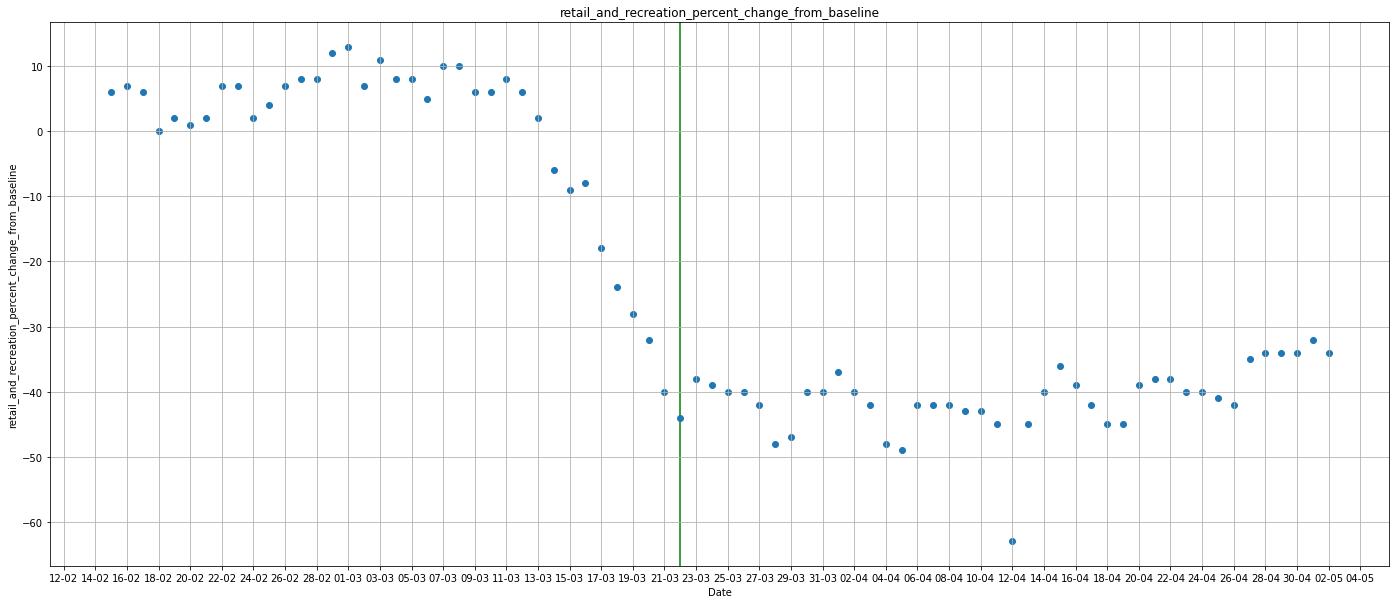

Linear Regression Model Score: 0.26433651696809624


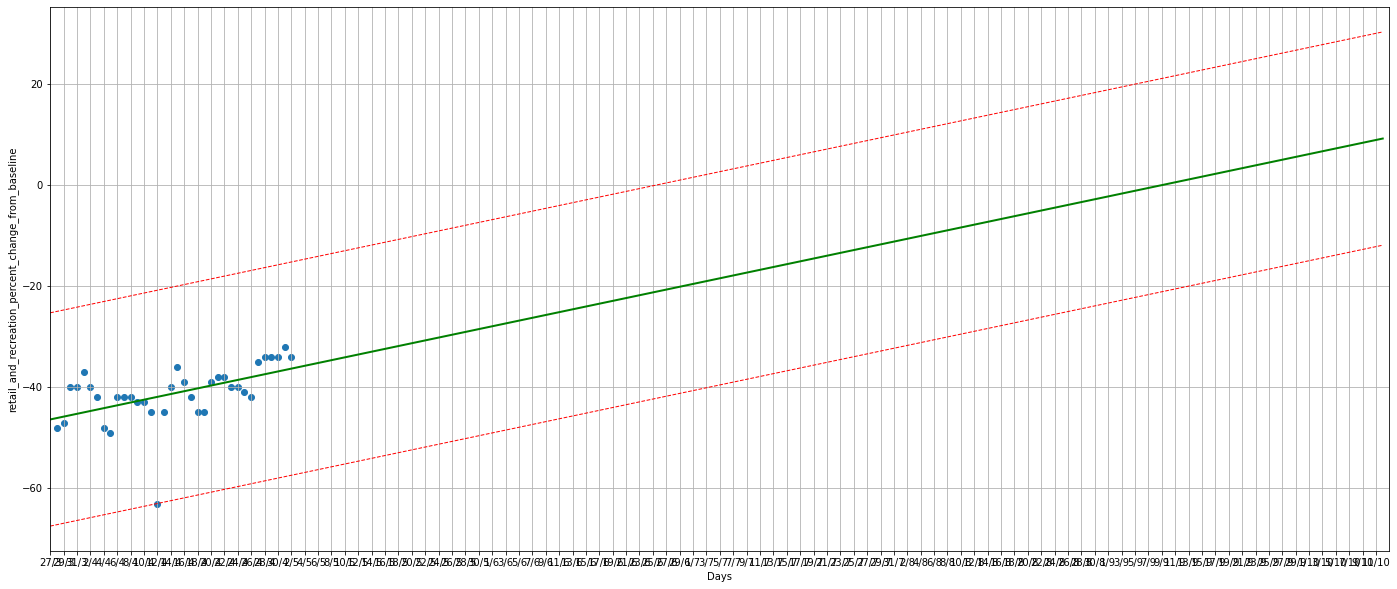

In [74]:
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing, linear_model
from sklearn.metrics import max_error
# sklean.linear_model import LinearRegression
from sklearn import neighbors
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.svm import SVR

from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


data = pd.read_csv('Global_Mobility_Report.csv')
data = data.loc[(data.country_region_code == 'US') & (data.sub_region_1.isnull())]

data = data.reset_index(drop=True)
# print(data)

dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

# rolling_average_days = 7
# data['retail_and_recreation_percent_change_from_baseline_moving'] = data['retail_and_recreation_percent_change_from_baseline'].rolling(window=rolling_average_days).mean()
# variable = 'retail_and_recreation_percent_change_from_baseline_moving'

variable = 'retail_and_recreation_percent_change_from_baseline'

fig, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.scatter(date_format, data[variable])
ax.set(xlabel="Date", ylabel=variable, title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.axvline(datetime(2020, 3, 22), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()

# prepare the lists for the model
X = date_format
y = data['retail_and_recreation_percent_change_from_baseline'].tolist()[1:]
# date format is not suitable for modeling, let's transform the date into incrementals number starting from starting_date
starting_date = 41
day_numbers = []
for i in range(1, len(X)):
    day_numbers.append([i])
X = day_numbers
# let's train our model only with data after the peak
X = X[starting_date:]
y = y[starting_date:]
# Instantiate Linear Regression
linear_regr = linear_model.LinearRegression()
# Train the model using the training sets
linear_regr.fit(X, y)
print("Linear Regression Model Score: %s" % (linear_regr.score(X, y)))

y_pred = linear_regr.predict(X)
error = max_error(y, y_pred)

X_test = []
future_days = 200
for i in range(starting_date, starting_date + future_days):
    X_test.append([i])
y_pred_linear = linear_regr.predict(X_test)

y_pred_max = []
y_pred_min = []
for i in range(0, len(y_pred_linear)):
    y_pred_max.append(y_pred_linear[i] + error)
    y_pred_min.append(y_pred_linear[i] - error)

# convert date of the epidemic peak into datetime format
date_zero = datetime.strptime(data['date'][starting_date], '%Y-%m-%d')
# creating x_ticks for making the plot more appealing
date_prev = []
x_ticks = []
step = 2
data_curr = date_zero
x_current = starting_date
n = int(future_days / step)
for i in range(0, n):
    date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
    x_ticks.append(x_current)
    data_curr = data_curr + timedelta(days=step)
    x_current = x_current + step

# plot known data
plt.figure(figsize=(24, 10))
plt.grid()
plt.scatter(X, y)
# plot linear regression prediction
plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
# plot maximum error
plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
# plot minimum error
plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.xlim(starting_date, starting_date + future_days)
plt.xticks(x_ticks, date_prev)
plt.ylabel('retail_and_recreation_percent_change_from_baseline')
plt.yscale('linear')
# plt.yscale('log')
# plt.gca().invert_yaxis()
plt.savefig('retail_and_recreation_percent_change_from_baseline_prediction.png')
plt.show()


Linear Regression Model Score: 0.2231224526056601
POLY Regression Model Score: 0.26415637316593055
RBF Regression Model Score: 0.7549528047532659
No handles with labels found to put in legend.


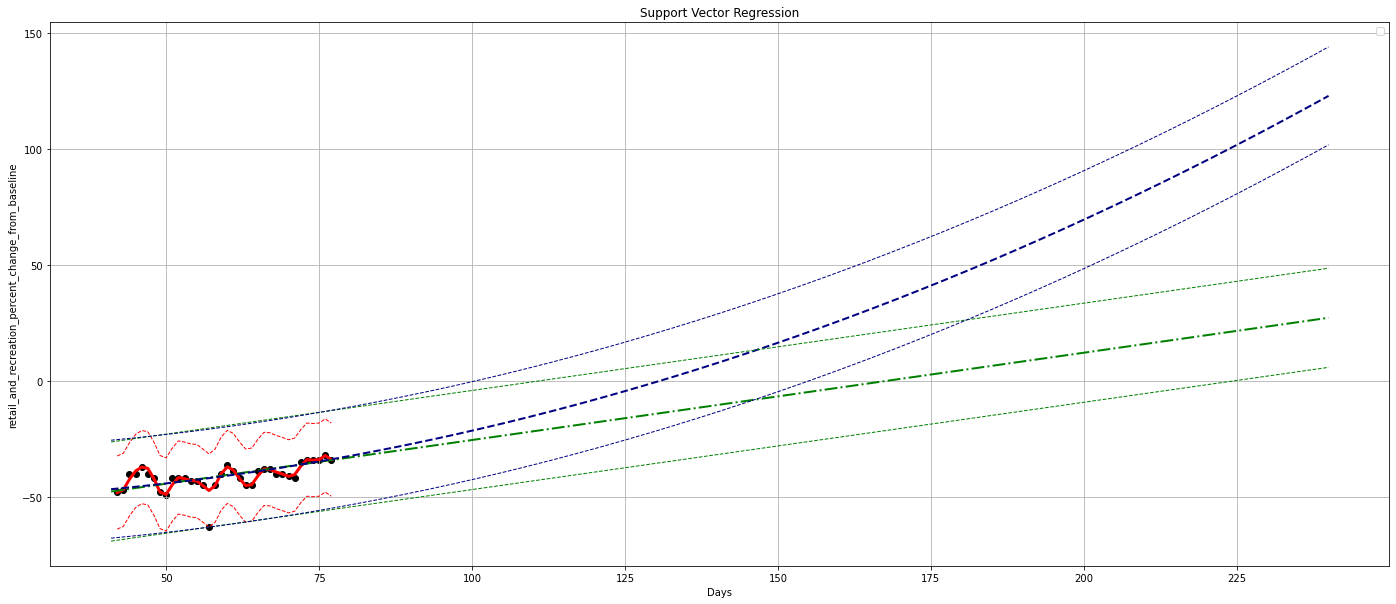

In [75]:
# Support Vector Regression
# #############################################################################
# Fit regression model
svr_lin = SVR(kernel='linear', C=1e3)
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y)
y_lin = svr_lin.fit(X, y)
y_poly = svr_poly.fit(X, y)
print("Linear Regression Model Score: %s" % (y_lin.score(X, y)))
print("POLY Regression Model Score: %s" % (y_poly.score(X, y)))
print("RBF Regression Model Score: %s" % (y_rbf.score(X, y)))


X_test = []
future_days = 200
for i in range(starting_date, starting_date + future_days):
    X_test.append([i])

y_pred_linear = y_lin.predict(X_test)
y_pred_poly = y_poly.predict(X_test)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

error_lin = max_error(y, y_lin)
error_rbf = max_error(y, y_rbf)
error_poly = max_error(y, y_poly)

y_pred_lin_max = []
y_pred_lin_min = []
y_pred_rbf_max = []
y_pred_rbf_min = []
y_pred_poly_max = []
y_pred_poly_min = []

for i in range(0, len(y_pred_linear)):
    y_pred_lin_max.append(y_pred_linear[i] + error_lin)
    y_pred_lin_min.append(y_pred_linear[i] - error_lin)
    y_pred_poly_max.append(y_pred_poly[i] + error_poly)
    y_pred_poly_min.append(y_pred_poly[i] - error_poly)

for i in range(0, len(y_rbf)):
    y_pred_rbf_max.append(y_rbf[i] + error_rbf)
    y_pred_rbf_min.append(y_rbf[i] - error_rbf)



# #############################################################################
# Look at the results
lw = 2
plt.figure(figsize=(24, 10))
plt.grid()
plt.xlabel('Days')
plt.ylabel('retail_and_recreation_percent_change_from_baseline')
plt.title('Support Vector Regression')
plt.legend()

plt.scatter(X, y, color='black', label='data')

plt.plot(X, y_rbf, color='red', lw=3, label='RBF model')
plt.plot(X_test, y_pred_linear, color='green', lw=lw, linestyle='-.', label='Linear model')
plt.plot(X_test, y_pred_poly, color='navy', lw=lw,
          linestyle='--', label='Polynomial model')

# plot maximum error
plt.plot(X, y_pred_rbf_max, color='red', linewidth=1, linestyle='dashed')
plt.plot(X_test, y_pred_lin_max, color='green', linewidth=1, linestyle='dashed')
plt.plot(X_test, y_pred_poly_max, color='navy', linewidth=1, linestyle='dashed')

# plot minimum error
plt.plot(X, y_pred_rbf_min, color='red', linewidth=1, linestyle='dashed')
plt.plot(X_test, y_pred_lin_min, color='green', linewidth=1, linestyle='dashed')
plt.plot(X_test, y_pred_poly_min, color='navy', linewidth=1, linestyle='dashed')

plt.show()



KNN Regression Model - uniform:  0.27773461945145794
KNN Regression Model - distance:  1.0


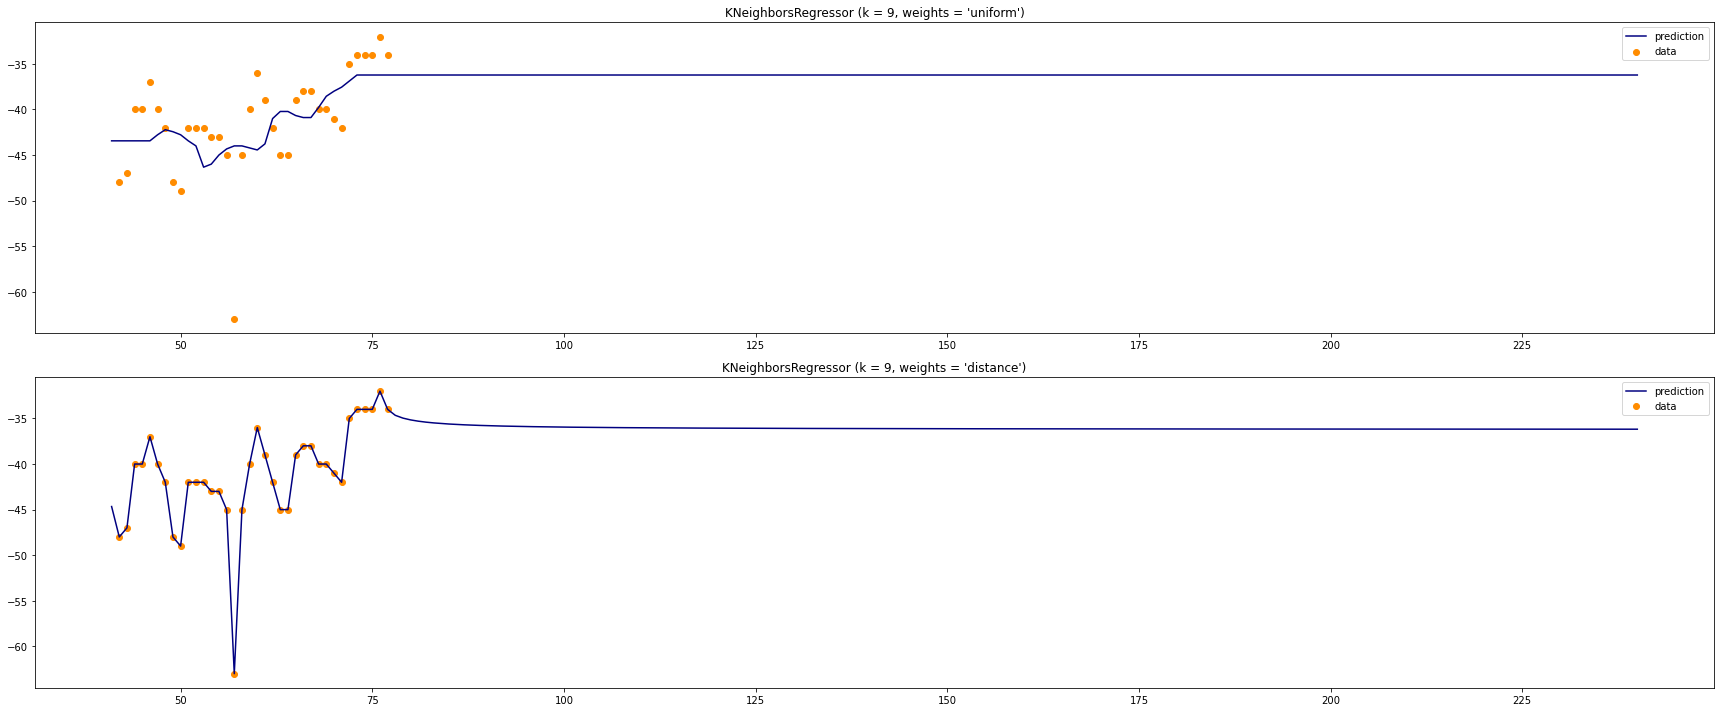

In [103]:
# #############################################################################
# Fit regression model
n_neighbors = 3
T = np.linspace(starting_date, future_days, 500)[:, np.newaxis]

plt.figure(figsize=(24, 10))
plt.grid()
plt.xlabel('Days')
plt.ylabel('retail_and_recreation_percent_change_from_baseline')

for i, weights in enumerate(['uniform','distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X, y).predict(X_test)
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, color='darkorange', label='data')
    plt.plot(X_test, y_, color='navy', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))
    print("KNN Regression Model - %s:  %s"  % (weights, knn.score(X, y)))

plt.tight_layout()
plt.show()

In [2]:
# #import required packages
# from sklearn import neighbors
# from sklearn.metrics import mean_squared_error 
# from math import sqrt
# import matplotlib.pyplot as plt
# %matplotlib inline

# rmse_val = [] #to store rmse values for different k
# for K in range(20):
#     K = K+1
#     model = neighbors.KNeighborsRegressor(n_neighbors = K)

#     model.fit(x_train, y_train)  #fit the model
#     pred=model.predict(x_test) #make prediction on test set
#     error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#     rmse_val.append(error) #store rmse values
#     print('RMSE value for k= ' , K , 'is:', error)

In [3]:
# # Robustly fit linear model with RANSAC algorithm
# ransac = linear_model.RANSACRegressor()
# ransac.fit(X, y)
# inlier_mask = ransac.inlier_mask_
# outlier_mask = np.logical_not(inlier_mask)

# # Predict data of estimated models
# line_y_ransac = ransac.predict(X)

# lw = 2
# plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
#             label='Inliers')
# plt.scatter(X[outlier_mask], y[outlier_mask], color='black', marker='+',
#             label='Outliers')
# plt.plot(line_X, line_y_ransac, color='black', linestyle='--', linewidth=lw,
#          label='RANSAC regressor')
# plt.legend(loc='lower right')
# plt.xlabel("Input")
# plt.ylabel("Response")
# plt.show()